# <font color='blue'>The Competition</font>

It can be hard to know how much something is really worth. Small details can mean big differences in pricing. For example, can you guess which one of the following sweaters costs 400 and which costs 9.99?

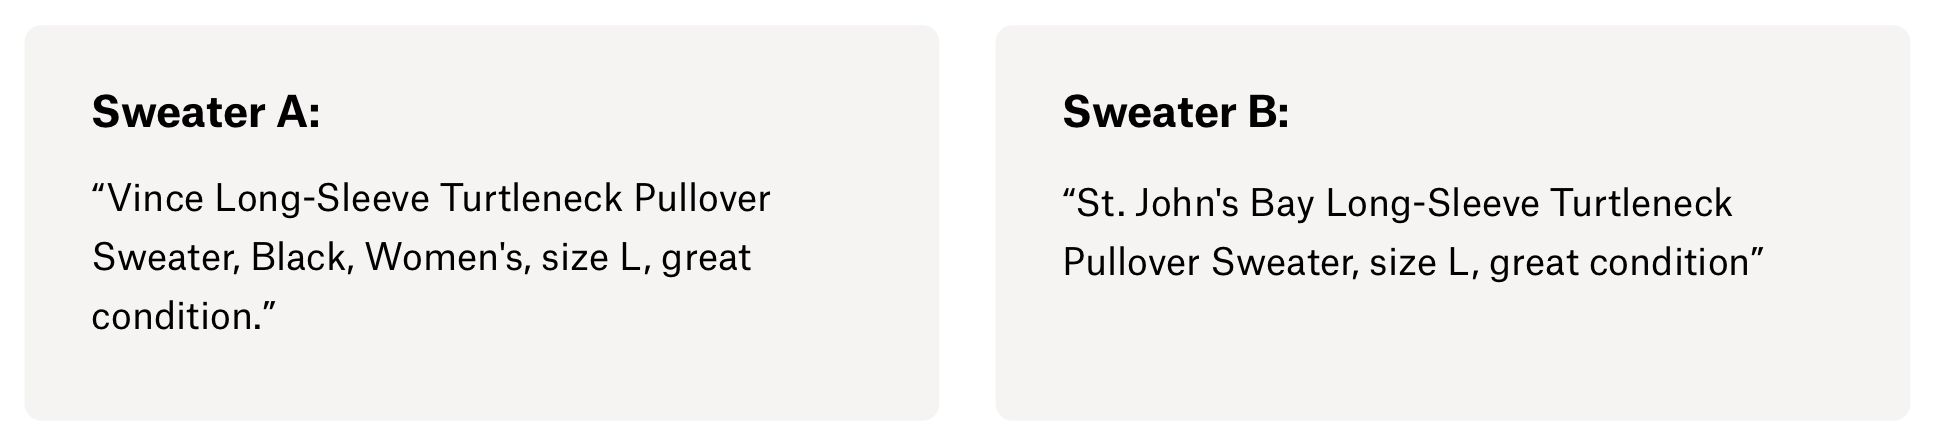


Product pricing gets even harder at scale, considering just how many products are sold online. Clothing has strong seasonal pricing trends and is heavily influenced by brand names, while electronics have fluctuating prices based on product specifications.

### Objective

In this competition, you will predict the sale price of a listing based on information a seller provides for this listing. Online marketplaces like Amazon provide this kind of insight. While these are real data, they are not from Amazon. You will be provided supplier-provided text descriptions of their products, including details like product category name, brand name, and item condition.

### About the Data

The file `final_data.zip` is located on eLC and has all necessary data to complete this project. There are two tab-delimited data files needed for this contest: `train.tsv` and `test.tsv`. Each file contains online product listings and contain the following variables:

* `train_id` or `test_id`: Listing identifier.


* `name`: Listing title. The data is cleaned to remove text that look like prices (e.g. \$20) to avoid "leakage." These removed prices are represented as [rm].


* `item_condition_id`: the condition of the items provided by the seller.


* `category_name`: category of the listing brand_name.


* `price`: The price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in `test.tsv`.


* `shipping`: Equals 1 (0) if shipping fee is paid by seller (buyer).


* `item_description` Item description. The data is cleaned to remove text that look like prices (e.g. \$20) to avoid "leakage." These removed prices are represented as [rm].

You will use `train.tsv` to develop informative figures of descriptive statistics for your final report and develop your model. Once you've trained your model, use `test.tsv` to make price predictions. While `train.tsv` has about 700k observations, `test.tsv` has 3.5m observations. I suggest developing your model initially by using a representative sample of `train.tsv` in order to speed things up.

In [1]:
import pandas as pd
import numpy as np

test =pd.read_csv('./test.tsv',sep='\t')
df = pd.read_csv('./train.tsv',sep='\t') 
exp = df
df['category_name'] = df['category_name'].fillna('Missing').astype(str)

In [2]:
test['category_name'] = test['category_name'].fillna('Missing').astype(str)

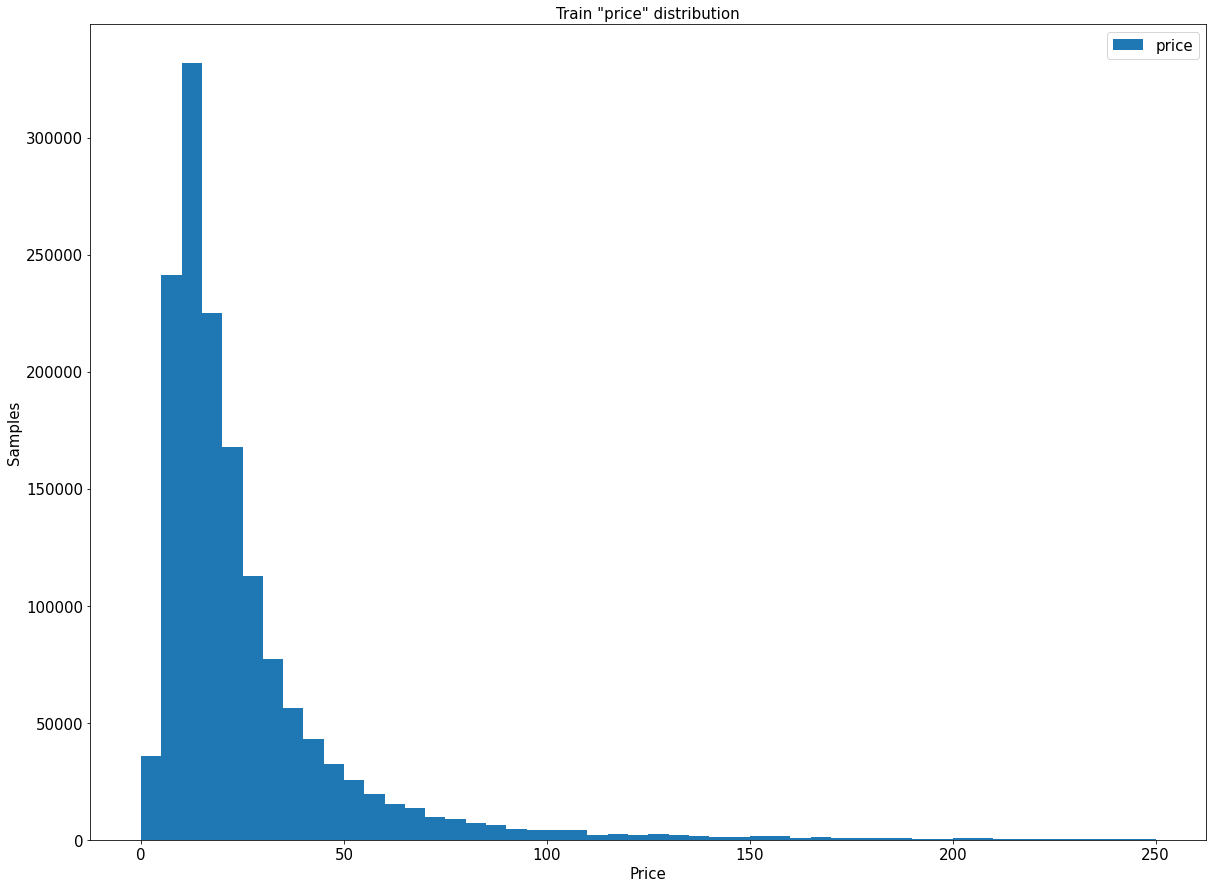

In [3]:
#Exploratory Analysis Visuals
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20, 15))
plt.hist(df['price'], bins=50, range=[0,250], label='price')
plt.title('Train "price" distribution', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [4]:
def transform_category_name(category_name):
    try:
        main, sub1, sub2= category_name.split('/')
        return main, sub1, sub2
    except:
        return np.nan, np.nan, np.nan

exp['category_main'], exp['category_sub1'], exp['category_sub2'] = zip(*exp['category_name'].apply(transform_category_name))
test['category_main'], test['category_sub1'], test['category_sub2'] = zip(*test['category_name'].apply(transform_category_name))

In [5]:
#How many unique main categories?
print("There are %d unique main categories." % exp['category_main'].nunique())

There are 10 unique main categories.


In [6]:
#lets get dummies for the categories


cats = pd.get_dummies(exp['category_main'])
cats_test = pd.get_dummies(test['category_main'])
exp2 = exp.drop("category_main", axis='columns')
exp2 = exp.drop("category_name", axis='columns')
test = test.drop('category_main', axis = 'columns')
test = test.drop('category_name', axis = 'columns')


In [7]:

exp2 = exp2.join(cats)
df = exp2
test = test.join(cats_test)

Men                      6.297524% of training data
Electronics              8.069354% of training data
Women                    44.814119% of training data
Home                     4.578037% of training data
Sports & Outdoors        1.641175% of training data
Vintage & Collectibles   3.138543% of training data
Beauty                   14.018421% of training data
Other                    3.059017% of training data
Kids                     11.580772% of training data
Handmade                 2.080221% of training data
nan			 0.722816% of training data


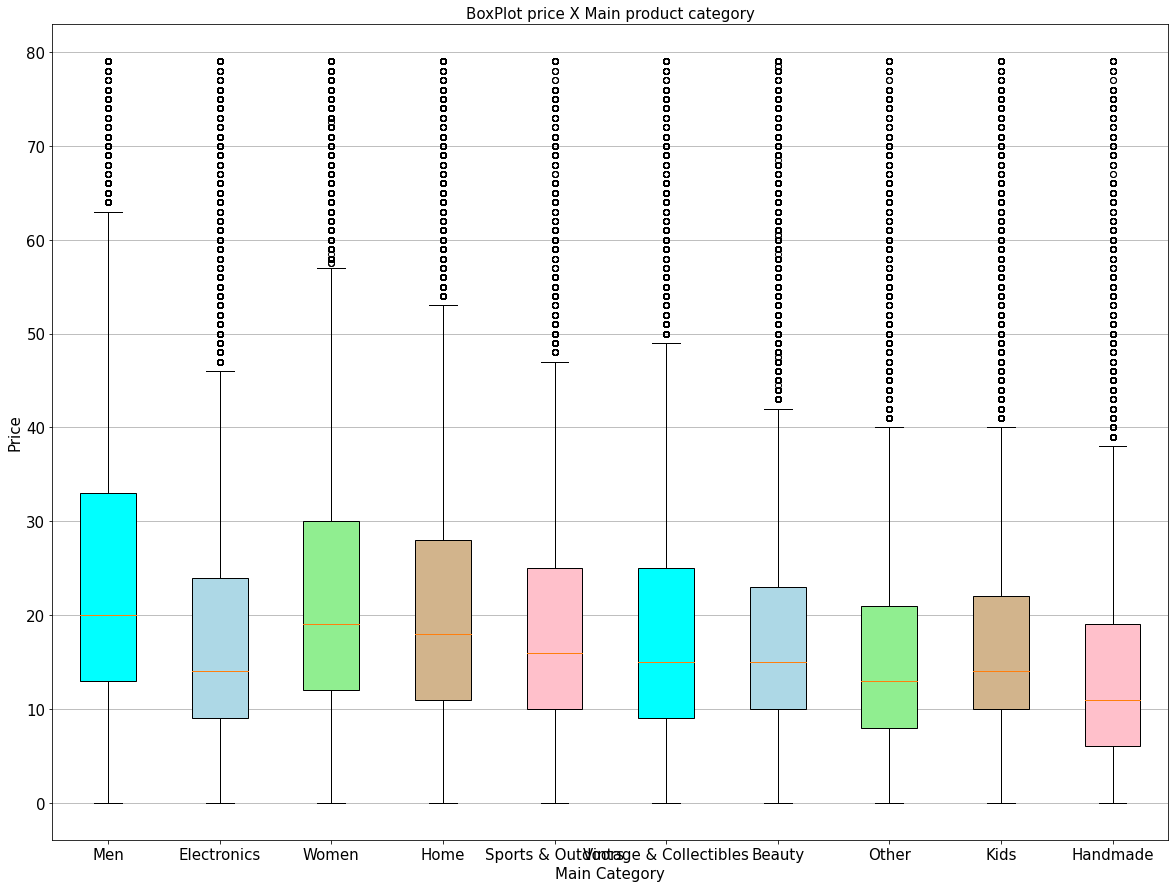

In [8]:
#Lets look at a price distribution for the categories

main_categories = [c for c in exp['category_main'].unique() if type(c)==str]
categories_sum=0
for c in main_categories:
    categories_sum+=100*len(exp[exp['category_main']==c])/len(exp)
    print('{:25}{:3f}% of training data'.format(c, 100*len(exp[exp['category_main']==c])/len(exp)))
print('nan\t\t\t {:3f}% of training data'.format(100-categories_sum))



exp = exp[exp['price']<80]

my_plot = []
for i in main_categories:
    my_plot.append(exp[exp['category_main']==i]['price'])
    
fig, axes = plt.subplots(figsize=(20, 15))
bp = axes.boxplot(my_plot,vert=True,patch_artist=True,labels=main_categories) 

colors = ['cyan', 'lightblue', 'lightgreen', 'tan', 'pink']*2
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

axes.yaxis.grid(True)

plt.title('BoxPlot price X Main product category', fontsize=15)
plt.xlabel('Main Category', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [9]:
#cleaning data

df['brand_name'] = df['brand_name'].fillna('Missing').astype(str)
df['shipping'] = df['shipping'].astype(str)
df['item_condition_id'] = df['item_condition_id'].astype(str)
df['item_description']  = df['item_description'].fillna(value= 'missing')

test['brand_name'] = test['brand_name'].fillna('Missing').astype(str)
test['shipping'] = test['shipping'].astype(str)
test['item_condition_id'] = test['item_condition_id'].astype(str)
test['item_description']  = test['item_description'].fillna(value= 'missing')


In [10]:
#data preprocessing
#df['price'] = np.log1p(df['price'])
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize as wt 
from nltk.corpus import stopwords

def stem_it(x):
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in x]

def remove_stops(x):
    stop_wrds = stopwords.words('english')
    temp = []
    for word in x:
        if word not in stop_wrds:
            temp.append(word)
    return temp



df['item_description'] = df['item_description'].str.lower()
df['item_description'] = df['item_description'].str.replace('[^A-Za-z]', ' ', regex=True)
df['item_description'] = df['item_description'].apply(wt)
df['item_description'] = df['item_description'].apply(remove_stops)
df['item_description'] = df['item_description'].apply(stem_it) 

test['item_description'] = test['item_description'].str.lower()
test['item_description'] = test['item_description'].str.replace('[^A-Za-z]', ' ', regex=True)
test['item_description'] = test['item_description'].apply(wt)
test['item_description'] = test['item_description'].apply(remove_stops)
test['item_description'] = test['item_description'].apply(stem_it)

# Join the list we created in each observation of the "Text" field
df['item_description'] = df['item_description'].str.join(' ')
test['item_description'] = test['item_description'].str.join(' ')

In [11]:
#creating a feature matrix
from sklearn.feature_extraction.text import CountVectorizer

matrix = CountVectorizer(max_features = 100)
X = matrix.fit_transform(df['item_description']).toarray()

y = df['price']


matrix2 = CountVectorizer(max_features = 100)
X2 = matrix.fit_transform(test['item_description']).toarray()

In [12]:
X = pd.DataFrame(X)
X2 = pd.DataFrame(X2)

In [13]:
r = df[['item_condition_id', 'shipping']]
r2 = test[['item_condition_id', 'shipping']]
cats = cats.join(r)
test_cats = cats_test.join(r2)

In [14]:
X = X.join(cats)
X2 = X2.join(test_cats)

In [15]:
# #what are the most commonly used words

# from wordcloud import WordCloud

# import seaborn as sns

# spam_words = ' '.join(df['item_description'])
# spam_wc = WordCloud(width = 600,height = 512).generate(spam_words)
# plt.figure(figsize = (12, 8), facecolor = 'k')
# plt.imshow(spam_wc)
# plt.axis('off')
# plt.tight_layout(pad = 0)
# plt.show()

In [16]:
#Splitting data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=4, test_size = 0.2)

In [17]:

from sklearn import linear_model
from sklearn.linear_model import RidgeCV
res_ridge = linear_model.Ridge(alpha =1 ,max_iter = 100, fit_intercept = True, normalize = False, solver = 'auto', random_state= 4).fit(X, df['price'])



c:\users\chris\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\users\chris\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [18]:
def rmsle(Y, Y_pred):
    assert Y.shape == Y_pred.shape
    return np.sqrt(np.mean(np.square(Y_pred - Y )))

In [21]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_log_error
predict1 = res_ridge.predict(X)
predict = res_ridge.predict(X2)

c:\users\chris\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\users\chris\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [3]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error


print(f'The logistic regression model has an R^2 of {r2_score(y_test,predict1):.2f}%')
print(f'The logistic regression model has a RMSLE of {mean_squared_log_error(y_test,predict1):.4f}%')

NameError: name 'y_test' is not defined

In [ ]:
predict = pd.Series(predict)

In [ ]:
sub = test[['test_id']]
sub['price'] = predict
sub

In [ ]:

sub = sub.rename(columns = {'test_id':'ID', 0 : 'Predicted Price'})
sub = sub.dropna()
sub.set_index('ID', inplace = True)

##sub.to_csv('sub.csv', index = False)